In [ ]:
# Imports

import pandas as pd
import numpy as np
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import keras.backend as K
import json
import requests

from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LSTM
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model

In [ ]:
# Gather Dataset

ent_ext_df = pd.read_csv("https://raw.githubusercontent.com/kkdelux/COMP542StockGAN/main/COMP542StockGANDataset.csv")

delayed_ent_ext_df = ent_ext_df[ent_ext_df["start_index"] >= 10]

delayed_ent_ext_df

,ticker,entry,exit,profit,days_to_wait,start_index
4,GE,8.23800,8.89450,0.079692,1,5
5,GE,8.53050,8.92700,0.046480,1,6
6,GE,8.64000,9.14303,0.058221,1,10
7,GE,8.79367,9.22800,0.049391,1,11
8,GE,8.29100,8.87600,0.070558,1,14
...,...,...,...,...,...,...
249627,LEN,70.31200,80.23300,0.141100,31,468
249628,LEN,74.75700,80.68900,0.079350,31,469
249629,LEN,73.88350,79.14800,0.071254,31,470
249630,LEN,74.27200,79.06800,0.064573,31,471


In [ ]:
# Gather Stock Bar Data

res = requests.get("https://raw.githubusercontent.com/kkdelux/COMP542StockGAN/main/stock_bars.json")

bars = res.json()

SYMBOLS = list(bars.keys())

In [ ]:
# Prepare Data for Discriminator

# Bars Data
bars_dfs = {ticker: pd.DataFrame(bars[ticker]) for ticker in SYMBOLS}

for ticker in SYMBOLS:
  bars_dfs[ticker] = bars_dfs[ticker].drop(labels="t", axis=1)

bars_np = {ticker: np.array(bars_dfs[ticker]) for ticker in SYMBOLS}

bars_np

# Entry/Exit Data
train_ent_ext_df = delayed_ent_ext_df.sample(frac=0.5)

# Put it together
train_bars = []
train_start_index = []
train_ent_ext = []
train_days = []

for index, row in train_ent_ext_df.iterrows():
  train_ent_ext.append([row["entry"], row["exit"]])
  train_days.append(float(row["days_to_wait"]))
  train_start_index.append([row["ticker"], row["start_index"]])

for row in train_start_index:
  idx = row[1]
  train_bars.append(bars_np[row[0]][idx-9:idx+1])

train_bars = np.array(train_bars)
train_ent_ext = np.array(train_ent_ext)
train_days = np.array(train_days)

train_bars.shape, len(train_bars)

((122620, 5, 5), 122620)

In [ ]:
# Prepare Data for Generator

# Sample ticker and start index from large df
generator_training_ticker_start_idx = delayed_ent_ext_df[["ticker","start_index"]].sample(frac=0.5)

generator_training_ticker_start_idx

,ticker,start_index
179252,SNAP,327
137315,WFC,26
154344,NRG,143
10641,NIO,171
37451,F,321
...,...,...
220637,SQ,439
11555,NIO,118
84094,CCL,380
57037,BAC,236


In [ ]:
# Build Discriminator (Generator Functions)

def build_discriminator():
  # Create input layers
  bar_input = Input(shape=(5,5), name="Bars Input")
  ent_ext_input = Input(shape=(2,), name="Entry/Exit Input")
  days_input = Input(shape=(1,), name="Days Input")

  # Bars Model Branch
  bars_model = LSTM(32, input_shape=(5,5,1), return_sequences=True, name="Discr_LSTM_32")(bar_input)
  bars_model = Dense(16, activation="relu")(bars_model)
  bars_model = LSTM(16, name="Discr_LSTM_16")(bars_model)
  bars_model = Dense(8, activation="relu")(bars_model)
  bars_model = Model(inputs=bar_input, outputs=bars_model)

  # Entry Exit Model Branch
  ent_ext_model = Dense(32, activation="relu")(ent_ext_input)
  ent_ext_model = Dense(16, activation="relu")(ent_ext_model)
  ent_ext_model = Model(inputs=ent_ext_input, outputs=ent_ext_model)

  # Days Model Branch
  days_model = Dense(4)(days_input)
  days_model = Model(inputs=days_input, outputs=days_model)

  # Combine Model Branches
  combined = concatenate([bars_model.output, ent_ext_model.output, days_model.output])

  # Form remainder of discriminator
  disc_model = Dense(4)(combined)
  disc_model = Dense(1, activation="sigmoid")(disc_model)

  # Return Complete Model
  return Model(inputs=[bar_input, ent_ext_input, days_input], outputs=disc_model)


In [ ]:
# Build Generator (Generator Functions)

def build_generator():
  # Create Input Layer
  bar_input = Input(shape=(5,5))

  # Generator Base Model
  gen_model = LSTM(32, input_shape=(5,5), activation="tanh", recurrent_activation="sigmoid")(bar_input)
  gen_model = Dense(32, activation="relu")(gen_model)

  # Generator Output Layers
  # -- Entry/Exit Layer
  ent_ext_layer = Dense(16, activation="relu")(gen_model)
  ent_ext_layer = Dense(2, activation="relu")(ent_ext_layer)

  # -- Days Layer
  days_layer = Dense(16, activation="relu")(gen_model)
  days_layer = Dense(1, activation="relu")(days_layer)

  # Generator Model
  return Model(inputs=bar_input, outputs=[ent_ext_layer, days_layer])

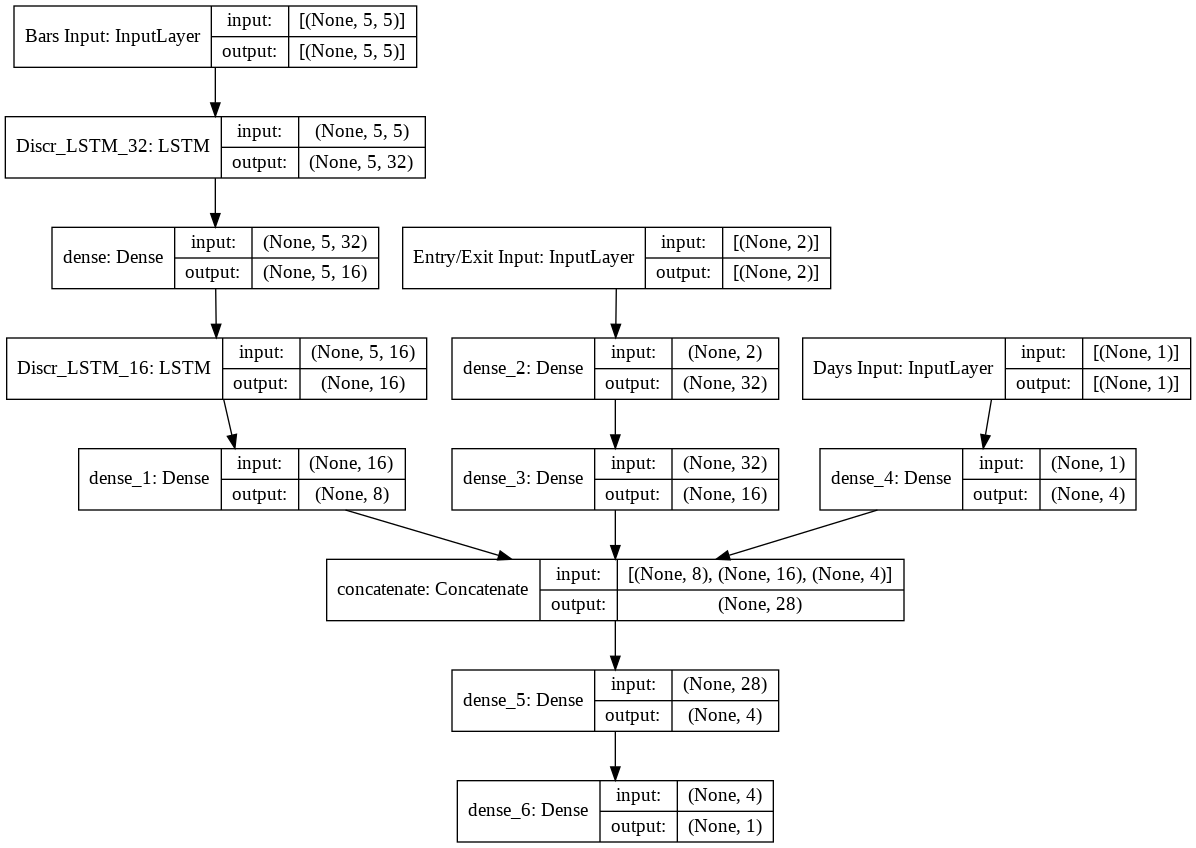

In [ ]:
discriminator = build_discriminator()

plot_model(discriminator, to_file="discriminator.png", show_shapes=True)

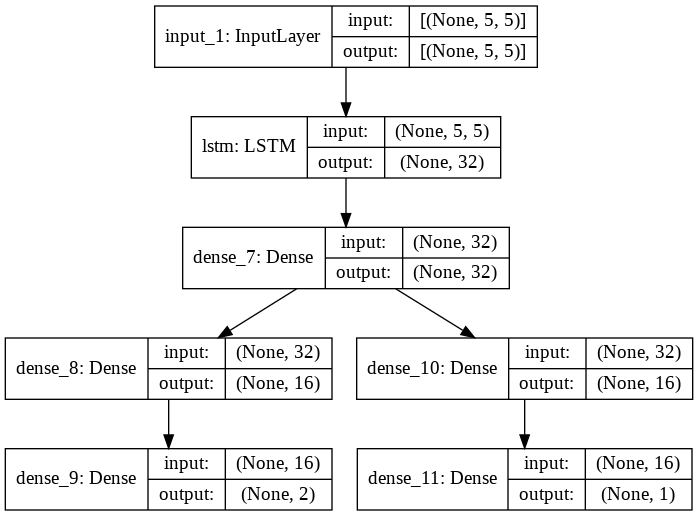

In [ ]:
generator = build_generator()

plot_model(generator, to_file="generator.png", show_shapes=True)

In [ ]:
# Sample Discriminator Prediction
discriminator([train_bars[:2], train_ent_ext[:2], train_days[:2]])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.05133685],
       [0.06714612]], dtype=float32)>

In [ ]:
# Sample Generator Prediciton

generator([train_bars[:2]])

[<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.6041732 , 0.43081996],
        [0.6041732 , 0.43081996]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[0.6261024],
        [0.6261024]], dtype=float32)>]

In [ ]:
# Training of GAN

# -- Batch Size
BATCH_SIZE = 1

# -- Optimizers
d_optimizer = Adam(learning_rate=0.00005, beta_1=0.7)
g_optimizer = Adam(learning_rate=0.0001, beta_1=0.7)

# -- Loss
loss_fn = BinaryCrossentropy(from_logits=True)

# -- Training Step
@tf.function
def train_step(real_bars, real_ent_ext, real_days):
  # Get random sets of tickers and endpoints from generator data set of the length BATCH_SIZE
  bars = []
  samples_df = generator_training_ticker_start_idx.sample(frac=BATCH_SIZE/len(generator_training_ticker_start_idx))
  # Convert tickers and start index into bars
  for index, row in samples_df.iterrows():
    ticker, start_idx = row
    bars.append(bars_np[ticker][start_idx-9:start_idx+1])
  # convert bars to a numpy array for processing
  bars = np.array(bars)

  # Generate data based on the fake bars
  generated_ent_ext_days = generator(bars)
  # Split generator data for labeling
  generated_ent_ext, generated_days = generated_ent_ext_days

  # combined data
  combined_bars = tf.concat([bars, real_bars], axis=0)
  combined_ent_ext = tf.concat([generated_ent_ext, real_ent_ext], axis=0)
  combined_days = tf.concat([generated_days, real_days], axis=0)

  # Label based on batch size
  labels = tf.concat(
      [tf.ones((BATCH_SIZE, 1)), tf.zeros((real_days.shape[0], 1))], axis=0
  )
  # Add random noise to the labels
  labels += 0.05 * tf.random.uniform(labels.shape)

  # Train the Discriminator
  with tf.GradientTape() as tape:
    predictions = discriminator([combined_bars, combined_ent_ext, combined_days], training=True)
    d_loss = loss_fn(labels, predictions)
  grads = tape.gradient(d_loss, discriminator.trainable_weights)
  d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))


  # Random bars data
  samples_df = generator_training_ticker_start_idx.sample(frac=BATCH_SIZE/len(generator_training_ticker_start_idx))
  # Convert tickers and start index into bars
  random_bars = []
  for index, row in samples_df.iterrows():
    ticker, start_idx = row
    random_bars.append(bars_np[ticker][start_idx-9:start_idx+1])
  # convert bars to a numpy array for processing
  random_bars = np.array(random_bars)
  # Generate misleading labels
  misleading_labels = tf.zeros((BATCH_SIZE, 1))

  # Train the Generator
  with tf.GradientTape() as tape:
    generated = generator(random_bars, training=True)
    predictions = discriminator([random_bars, generated[0], generated[1]])
    g_loss = loss_fn(misleading_labels, predictions)
  grads = tape.gradient(g_loss, generator.trainable_weights)
  g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))

  return d_loss, g_loss

In [ ]:
# Training loop

EPOCHS = 2

steps = []
d_losses = []
g_losses = []

for epoch in range(EPOCHS):
  print("\nStart epoch", epoch)

  for step in range(BATCH_SIZE, len(train_bars), BATCH_SIZE):
    real_bars = train_bars[step-BATCH_SIZE:step]
    real_ent_ext = train_ent_ext[step-BATCH_SIZE:step]
    real_days = train_days[step-BATCH_SIZE:step]

    # Train Discriminator and Generator on one batch of real data
    d_loss, g_loss = train_step(real_bars, real_ent_ext, real_days.reshape(BATCH_SIZE, 1))
    
    steps.append(step)
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if step % 500 == 0:
      # Print Metrics
      print("Loss at step %d: Discriminator %.2f | Generator %.2f" % (step, d_loss, g_loss))
      


Start epoch 0
Loss at step 500: Discriminator 0.31 | Generator 0.86
Loss at step 1000: Discriminator 0.63 | Generator 1.02
Loss at step 1500: Discriminator 0.82 | Generator 1.08
Loss at step 2000: Discriminator 0.96 | Generator 0.97
Loss at step 2500: Discriminator 0.52 | Generator 1.01
Loss at step 3000: Discriminator 0.76 | Generator 0.84
Loss at step 3500: Discriminator 0.74 | Generator 0.87
Loss at step 4000: Discriminator 0.69 | Generator 0.76
Loss at step 4500: Discriminator 0.76 | Generator 0.72
Loss at step 5000: Discriminator 0.72 | Generator 0.86
Loss at step 5500: Discriminator 0.63 | Generator 0.85
Loss at step 6000: Discriminator 0.66 | Generator 0.79
Loss at step 6500: Discriminator 0.79 | Generator 0.59
Loss at step 7000: Discriminator 0.75 | Generator 0.71
Loss at step 7500: Discriminator 0.73 | Generator 0.76
Loss at step 8000: Discriminator 0.70 | Generator 0.75
Loss at step 8500: Discriminator 0.67 | Generator 0.78
Loss at step 9000: Discriminator 0.67 | Generator 0

In [ ]:
ticker, start_index = generator_training_ticker_start_idx.iloc[0]

sample_bars = bars_np[ticker][start_index-4:start_index+1]

sample_bars = sample_bars.reshape(1,5,5)

sample_bars, generator(sample_bars)

(array([[[1.3460000e+01, 1.3690000e+01, 1.3370000e+01, 1.3590000e+01,
          2.7294146e+07],
         [1.3630000e+01, 1.3650000e+01, 1.2630000e+01, 1.3030000e+01,
          6.0542994e+07],
         [1.3200000e+01, 1.3465000e+01, 1.2840000e+01, 1.2955000e+01,
          4.0782300e+07],
         [1.2770000e+01, 1.3335000e+01, 1.2520000e+01, 1.2915000e+01,
          5.0231674e+07],
         [1.2710000e+01, 1.3040000e+01, 1.2440000e+01, 1.2442700e+01,
          5.8959180e+07]]]),
 [<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[53.263   , 56.682396]], dtype=float32)>,
  <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[14.114012]], dtype=float32)>])